In [76]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
from scipy.signal import welch
import scipy.stats
import math
import collections
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
#from sklearn import datasets

patients_files_to_be_used = ['P01.mat','P02.mat','P03.mat','P04.mat','P05.mat','P06.mat','P07.mat','P08.mat',
                             'P09.mat','P10.mat',
                             'S01.mat','S02.mat','S03.mat','S04.mat','S05.mat','S06.mat','S07.mat','S08.mat',
                             'S09.mat','S10.mat']
patients_labels = ['P' for _ in range(0, 10)] + ['S' for _ in range(0, 10)]



In [3]:
features_len = 24
patient_features = np.zeros((len(patients_files_to_be_used),features_len))

def normalize_frequency_bands(pot):
	total_potency = pot.sum()
	alpha_band_potency = pot[:,:,0:4].sum()
	factor_alpha_band = alpha_band_potency / total_potency
	pot[:,:,0:4] = pot[:,:,0:4] * factor_alpha_band

	delta_band_potency = pot[:,:,4:7].sum()
	factor_delta_band = delta_band_potency / total_potency
	pot[:,:,4:7] = pot[:,:,4:7] * factor_delta_band

	theta_band_potency = pot[:,:,7:11].sum()
	factor_theta_band = theta_band_potency / total_potency
	pot[:,:,7:11] = pot[:,:,7:11] * factor_theta_band

	beta_band_potency = pot[:,:,11:27].sum()
	factor_beta_band = beta_band_potency / total_potency
	pot[:,:,11:27] = pot[:,:,11:27] * factor_alpha_band

	gamma_band_potency = pot[:,:,27:].sum()
	factor_gamma_band = gamma_band_potency / total_potency
	pot[:,:,27:] = pot[:,:,27:] * factor_gamma_band
	return pot

def calculate_entrophy(bins, X, from_discrete):
	entrophy = 0
	for v in X:
		if from_discrete:
			quantity_of_apparitions_v = bins[v]
		else:
			quantity_of_apparitions_v = bins[int(v) - 1][2]
		probability = quantity_of_apparitions_v / float(len(X))
		entrophy = entrophy + probability * math.log(probability)
	return entrophy * -1

def intra_electrod_entrophy_median_for_patients(patients_files_to_use):
	patients_entrophies = np.zeros(len(patients_files_to_use) * 4)
	for file_index,file_name in enumerate(patients_files_to_use):
		current_patient_epochs = scipy.io.loadmat(file_name)['data'][:,[8,44,80,131]]
		for electrod_index in range(0, 4):
			electrod_entrophy_med = 0
			for epoch_index in range(0, len(current_patient_epochs)):
				epoch_discretization_bins = calculate_discretization(current_patient_epochs[epoch_index, electrod_index])
				electrod_entrophy_med += calculate_entrophy(epoch_discretization_bins, current_patient_epochs[epoch_index, electrod_index], False)
			patients_entrophies[electrod_index + file_index * 4] = electrod_entrophy_med / len(current_patient_epochs)
	return patients_entrophies

def define_new_chain_symbols(symbols1, symbols2):
	res = np.zeros(len(symbols1))
	i = 0
	for symbol_from_1, symbol_from_2 in zip(symbols1, symbols2):
		res[i] = int(str(int(symbol_from_1)) + str(int(symbol_from_2)))
		i += 1
	return res

def inter_two_electrods_entrophy_median_by_epochs_for_patients(patients_files_to_use):
	patients_entrophies = np.zeros(len(patients_files_to_use))
	for file_index, file_name in enumerate(patients_files_to_use):
		patient_entrophy_med = 0
		current_patient_epochs = scipy.io.loadmat(file_name)['data'][:,[8,44]]
		epochs_pair_inter_electrod = zip(current_patient_epochs[:,0], current_patient_epochs[:,1])
		for electrod_0_epoch, electrod_1_epoch in epochs_pair_inter_electrod:
			calculate_discretization(electrod_0_epoch)
			calculate_discretization(electrod_1_epoch)
			inter_electrod_epoch_symbols = define_new_chain_symbols(electrod_0_epoch, electrod_1_epoch)
			bins = collections.Counter(inter_electrod_epoch_symbols)
			patient_entrophy_med += calculate_entrophy(bins, inter_electrod_epoch_symbols, True)
		patients_entrophies[file_index] = patient_entrophy_med / len(current_patient_epochs)
	return patients_entrophies

def calculate_discretization(x):
	iqr = scipy.stats.iqr(x)
	N = math.ceil((x.max() - x.min()) / (2*iqr*math.pow(len(x), -1/3)))
	bin_size = (x.max() - x.min()) / N
	bins = np.zeros((int(N),3))
	current_boundary = x.min()
	for i in range(0, int(N)):
		bins[i] = np.array([current_boundary, current_boundary + bin_size, 0])
		current_boundary = current_boundary + bin_size
    #Extended size for first and last bin due to precission issue.
	bins[int(N)-1][1] = bins[int(N)-1][1] + bin_size
	bins[0][0] = bins[0][0] - bin_size
	for i, v in enumerate(x):
		for bin_index in range(0, int(N)):
			current_bin = bins[bin_index] 
			if current_bin[0] <= v and v < current_bin[1]:
				current_bin[2] = current_bin[2] + 1
				x[i] = bin_index + 1
	return bins


## Extraccion de Features:

In [12]:
for index_file_name, file_name in enumerate(patients_files_to_be_used):
    current_patient_data = scipy.io.loadmat(file_name)['data']
    current_patient_data_1_electrod= current_patient_data[:,[8]]
    frec, pot = welch(current_patient_data_1_electrod, fs=250,nperseg = 201)
    avg_pot_inter_electrod_by_epoch = pot.mean(axis=0).mean(axis=0)
    avg_pot_inter_elec_by_epoch_delta = avg_pot_inter_electrod_by_epoch[0:4]
    patient_features[index_file_name,0] = avg_pot_inter_elec_by_epoch_delta.mean()
    patient_features[index_file_name,1] = avg_pot_inter_elec_by_epoch_delta.std()
    
    avg_pot_inter_elec_by_epoch_beta = avg_pot_inter_electrod_by_epoch[4:7]
    patient_features[index_file_name,2] = avg_pot_inter_elec_by_epoch_beta.mean()
    patient_features[index_file_name,3] = avg_pot_inter_elec_by_epoch_beta.std()
    
    avg_pot_inter_elec_by_epoch_alpha = avg_pot_inter_electrod_by_epoch[7:11]
    patient_features[index_file_name,4] = avg_pot_inter_elec_by_epoch_alpha.mean()
    patient_features[index_file_name,5] = avg_pot_inter_elec_by_epoch_alpha.std()
    
    avg_pot_inter_elec_by_epoch_theta = avg_pot_inter_electrod_by_epoch[11:27]
    patient_features[index_file_name,6] = avg_pot_inter_elec_by_epoch_theta.mean()
    patient_features[index_file_name,7] = avg_pot_inter_elec_by_epoch_theta.std()
    
    avg_pot_inter_elec_by_epoch_gamma = avg_pot_inter_electrod_by_epoch[27:]
    patient_features[index_file_name,8] = avg_pot_inter_elec_by_epoch_gamma.mean()
    patient_features[index_file_name,9] = avg_pot_inter_elec_by_epoch_gamma.std()
    
    pot = normalize_frequency_bands(pot)
    
    avg_pot_inter_electrod_by_epoch = pot.mean(axis=0).mean(axis=0)
    avg_pot_inter_elec_by_epoch_delta = avg_pot_inter_electrod_by_epoch[0:4]
    patient_features[index_file_name,10] = avg_pot_inter_elec_by_epoch_delta.mean()
    patient_features[index_file_name,11] = avg_pot_inter_elec_by_epoch_delta.std()
    
    avg_pot_inter_elec_by_epoch_beta = avg_pot_inter_electrod_by_epoch[4:7]
    patient_features[index_file_name,12] = avg_pot_inter_elec_by_epoch_beta.mean()
    patient_features[index_file_name,13] = avg_pot_inter_elec_by_epoch_beta.std()
    
    avg_pot_inter_elec_by_epoch_alpha = avg_pot_inter_electrod_by_epoch[7:11]
    patient_features[index_file_name,14] = avg_pot_inter_elec_by_epoch_alpha.mean()
    patient_features[index_file_name,15] = avg_pot_inter_elec_by_epoch_alpha.std()
    
    avg_pot_inter_elec_by_epoch_theta = avg_pot_inter_electrod_by_epoch[11:27]
    patient_features[index_file_name,16] = avg_pot_inter_elec_by_epoch_theta.mean()
    patient_features[index_file_name,17] = avg_pot_inter_elec_by_epoch_theta.std()
    
    avg_pot_inter_elec_by_epoch_gamma = avg_pot_inter_electrod_by_epoch[27:]
    patient_features[index_file_name,18] = avg_pot_inter_elec_by_epoch_gamma.mean()
    patient_features[index_file_name,19] = avg_pot_inter_elec_by_epoch_gamma.std()
    
    entrophies_intra_electrods = intra_electrod_entrophy_median_for_patients(np.array([file_name]))
    median_entrophies_intra_electrods = entrophies_intra_electrods.mean()
    patient_features[index_file_name,20] = median_entrophies_intra_electrods
    std_entrophies_intra_electrods = entrophies_intra_electrods.std()
    patient_features[index_file_name,21] = std_entrophies_intra_electrods
    
    entrophies_inter_electrods = inter_two_electrods_entrophy_median_by_epochs_for_patients(np.array([file_name]))
    median_entrophies_inter_electrods = entrophies_inter_electrods.mean()
    patient_features[index_file_name,22] = median_entrophies_inter_electrods
    std_entrophies_inter_electrods = entrophies_inter_electrods.std()
    patient_features[index_file_name,23] = std_entrophies_inter_electrods  

In [38]:
#guardando datos
np.savetxt('patient_features.txt',patient_features)  
    

### Cargo datos

In [40]:
#cargando datos
patient_features = np.loadtxt('patient_features.txt',)


## Curvas ROC: 

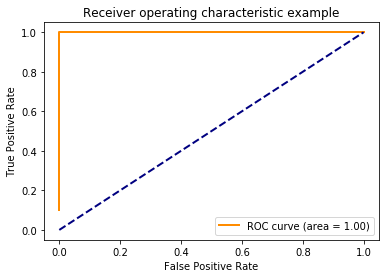

In [48]:
#Feature avg_pot_inter_elec_by_epoch_delta_mean 
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,0],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

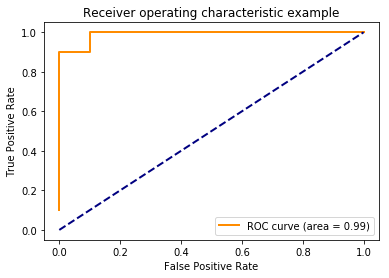

In [49]:
#Feature avg_pot_inter_elec_by_epoch_delta_std
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,1],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

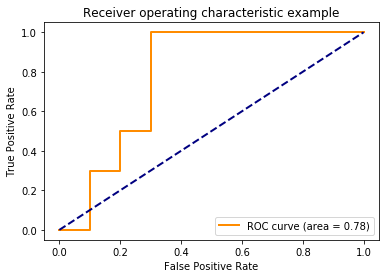

In [50]:
#Feature avg_pot_inter_elec_by_epoch_THETA_mean
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,2],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

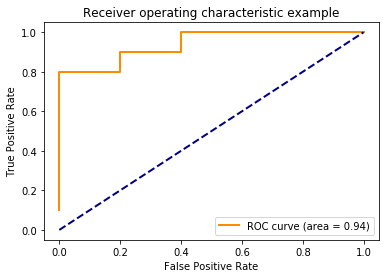

In [52]:
#Feature avg_pot_inter_elec_by_epoch_THETA_STD
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,3],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

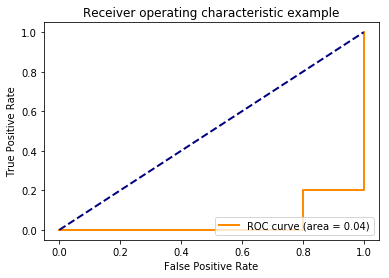

In [53]:
#Feature avg_pot_inter_elec_by_epoch_ALPHA_MEAN
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,4],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

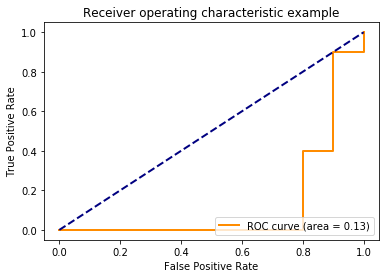

In [54]:
#Feature avg_pot_inter_elec_by_epoch_ALPHA_STD
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,5],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

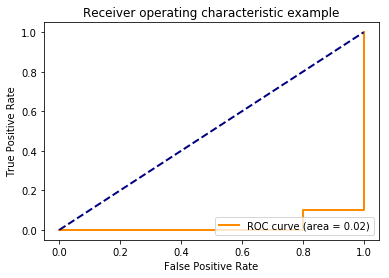

In [56]:
#Feature avg_pot_inter_elec_by_epoch_BETA_MEAN
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,6],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

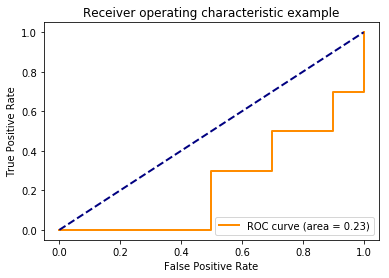

In [57]:
#Feature avg_pot_inter_elec_by_epoch_BETA_STD
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,7],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

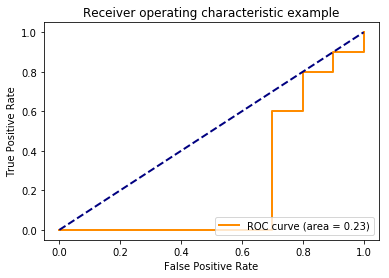

In [58]:
#Feature avg_pot_inter_elec_by_epoch_GAMMA_MEAN
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,8],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

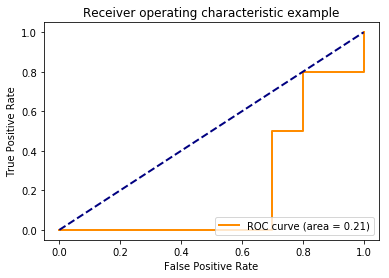

In [59]:
#Feature avg_pot_inter_elec_by_epoch_GAMMA_STD
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,9],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

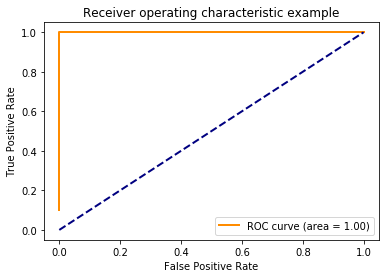

In [60]:
#Feature avg_pot_inter_elec_by_epoch_DELTA_NORMOLIZED_mean
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,10],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

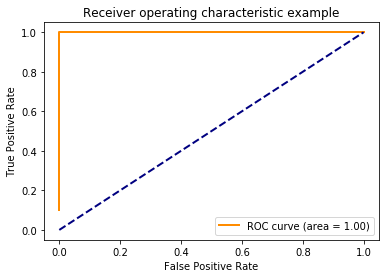

In [61]:
#Feature avg_pot_inter_elec_by_epoch_DELTA_NORMOLIZED_STD
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,11],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

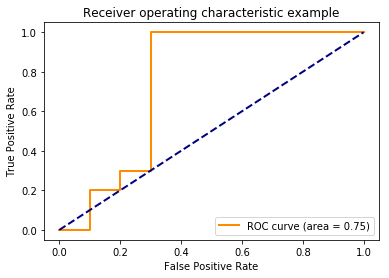

In [62]:
#Feature avg_pot_inter_elec_by_epoch_THETA_NORMOLIZED_mean
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,12],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

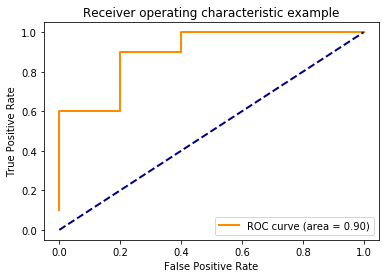

In [70]:
#Feature avg_pot_inter_elec_by_epoch_THETA_NORMOLIZED_STD
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,13],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

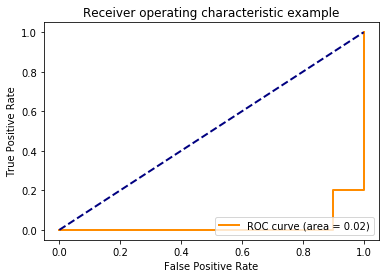

In [64]:
#Feature avg_pot_inter_elec_by_epoch_ALPHA_NORMOLIZED_mean
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,14],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

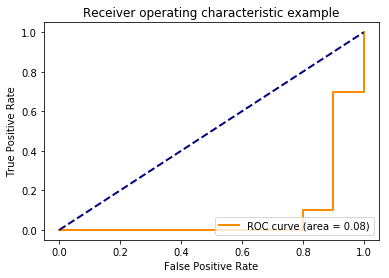

In [65]:
#Feature avg_pot_inter_elec_by_epoch_ALPHA_NORMOLIZED_STD
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,15],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

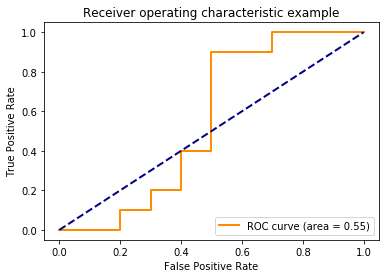

In [66]:
#Feature avg_pot_inter_elec_by_epoch_BETA_NORMOLIZED_mean
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,16],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

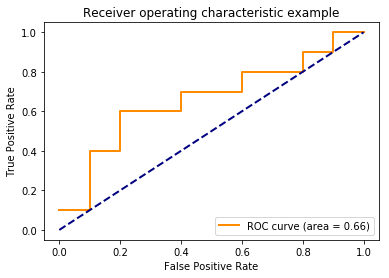

In [67]:
#Feature avg_pot_inter_elec_by_epoch_BETA_NORMOLIZED_STD
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,17],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

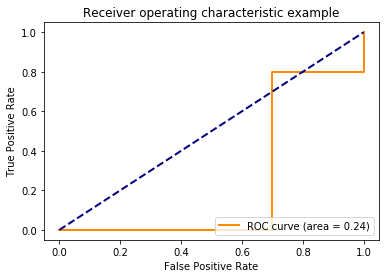

In [68]:
#Feature avg_pot_inter_elec_by_epoch_GAMMA_NORMOLIZED_mean
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,18],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

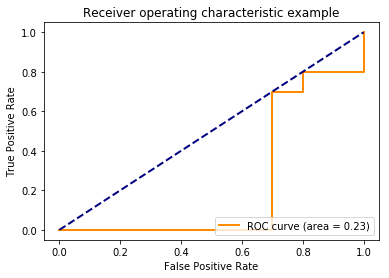

In [71]:
#Feature avg_pot_inter_elec_by_epoch_GAMMA_NORMOLIZED_STD
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,19],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

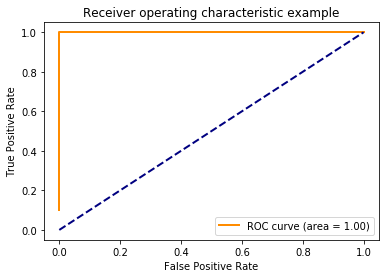

In [72]:
#Feature INTRA_ELECTRO_MEAN
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,20],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

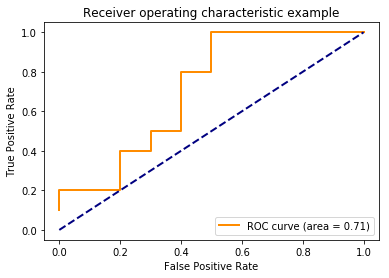

In [73]:
#Feature INTRA_ELECTROD_STD
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,21],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

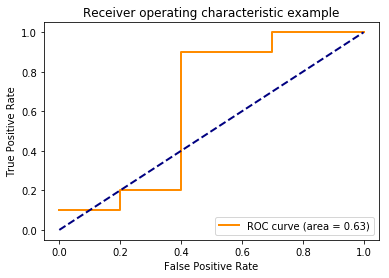

In [74]:
#Feature INTER_ELECTRO_MEAN
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,22],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

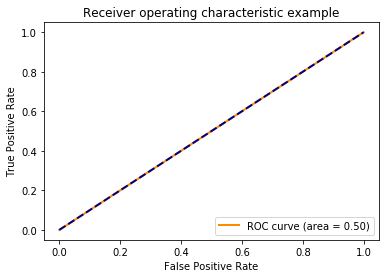

In [75]:
#Feature INTER_ELECTROD_STD
fpr,tpr,_ = metrics.roc_curve(y_true=patients_labels, y_score=patient_features[:,23],pos_label='P')
lw = 2
roc_auc = metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Ejercicio 2.b) Logistic regression

In [128]:

paients = patient_features[[1,3,12,16],8:9]
labels = np.array(patients_labels)
logistic = LogisticRegression()
logistic.fit(patient_features[[1,2,3,4,5,12,13,14,15,16],0:1],labels[[1,2,3,4,5,12,13,14,15,16]])
print(logistic.predict(patient_features[[8,9,18,19],0:1]))

#ARREGLO CON LA PORBABILIDAD QUE EL PACIENTE SEA P O S
logistic.predict_proba(patient_features[[8,9,18,19],0:1])

['P' 'P' 'P' 'P']


array([[ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0.5]])

array(['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S'],
      dtype='<U1')